In [1]:
import re, math
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import nfldb
import sys
import matplotlib as mpl
import seaborn as sns
from __future__ import division
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.libqsturng import psturng
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
# configure matplotlib plots
%matplotlib inline
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = [12, 9]#[10, 7.5]
mpl.rcParams['figure.dpi'] = 90
mpl.rcParams['savefig.dpi'] = 100
# configure seaborn plots
sns.set(style="whitegrid", color_codes=True)

yrType = '2016 Regular Season'

In [3]:
# functions
def icol(df, cols):
    return [i for i, dfCol in enumerate(df.columns) for col in cols if dfCol==col]

def appStrs(cols, string):
    return [c + string for c in cols]

In [4]:
# load proccessed data
plays = pd.read_csv('data/2016_reg_plays_gd.csv')

In [5]:
# play lables
playType = ['pass', 'rush']
playDir = ['left', 'up the middle', 'right']
playCols = [t + '_' + d[-6:] for t in playType for d in playDir]
# Feature column names: primarily cum sum stats columns - initially
col2cum = [c for c in plays.columns for x in ['type', 'dir', 'first', 'third', 'fourth', 'offense', 'passing', 'receiving', 'rushing'] if c.startswith(x) and not c.endswith('downs') and not c.endswith('_sh1') and not c.endswith('cum_dr') and not c.endswith('cum_gm')]
gcumCols = appStrs(col2cum, '_cum_gm')
dcumCols = appStrs(col2cum, '_cum_dr')
cumCols = gcumCols + dcumCols
prevPlay = appStrs(col2cum, '_sh1')
plays.pos_team = plays.pos_team.astype('category')
plays['pos_team_code'] = plays.pos_team.cat.codes
### - INCORPORATE THESE INTO plays_setup in future feature engineering
# DRIVE cumulative stats: fill NaN in columns with 0
plays[dcumCols] = plays[dcumCols].fillna(0)
# GAME cumulative stats: fill NaN in columns with forward fill
plays[gcumCols] = plays.groupby(['gsis_id', 'pos_team'])[gcumCols].fillna(method='ffill')
# GAME: cumulative stats: fill first play of game with 0
plays[gcumCols] = plays[gcumCols].fillna(0)
# Noncumulative, shifted stats: fill first play of game with 0
plays[prevPlay] = plays[prevPlay].fillna(0)
###
plays.play = plays.play.astype('category')
plays['play_code'] = plays.play.cat.codes
plays.play_type = plays.play_type.astype('category')
plays['play_type_code'] = plays.play_type.cat.codes
plays.play_dir = plays.play_dir.astype('category')
plays['play_dir_code'] = plays.play_dir.cat.codes

In [6]:
plays = plays.drop(['Unnamed: 0'], axis=1)#, 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis=1)
plays.head()

,gsis_id,pos_team,drive_id,description,down,drive,first_down,fourth_down_att,fourth_down_conv,fourth_down_failed,...,def_SF,def_TB,def_TEN,def_WAS,day_Monday,day_Saturday,day_Sunday,day_Thursday,play_type_code,play_dir_code
0,2016090800,CAR,2,(11:37) J.Stewart up the middle to CAR 35 for ...,1.0,[Touchdown ] CAR from OWN 29 to OPP 14 (last...,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
1,2016090800,CAR,2,(11:01) (Shotgun) J.Stewart left end to CAR 46...,2.0,[Touchdown ] CAR from OWN 29 to OPP 14 (last...,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,2016090800,CAR,2,(10:21) (Shotgun) M.Tolbert right guard to CAR...,1.0,[Touchdown ] CAR from OWN 29 to OPP 14 (last...,0,0,0,0,...,0,0,0,0,0,0,0,1,1,2
3,2016090800,CAR,2,(9:39) (Shotgun) C.Newton pass incomplete shor...,2.0,[Touchdown ] CAR from OWN 29 to OPP 14 (last...,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,2016090800,CAR,2,(9:35) (Shotgun) C.Newton pass deep middle to ...,3.0,[Touchdown ] CAR from OWN 29 to OPP 14 (last...,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1


# Inferential Statistics

In [29]:
def anova1DfCols(df, col1, col2):
    ''' 
    One-way ANOVA w/ eta-squared effect size
    on pandas DataFrame series 
    '''
    print(col1 + ' compared between ' + col2 + ' \n One-way ANOVA')
    mod = ols(col1 + ' ~ ' + col2, data=df).fit()
    ano_tab = sm.stats.anova_lm(mod, typ=2)
    print(ano_tab)
    # eta squared - effect size
    esq = ano_tab['sum_sq'][0]/(ano_tab['sum_sq'][0]+ano_tab['sum_sq'][1])
    print('\neta^2: {0}'.format(esq))
    
def pairwiseMC(ser, grp, alpha):
    '''
    pairwise multi-comparisons with tukeyhsd
    '''
    res = pairwise_tukeyhsd(ser, grp, alpha)
    pvals = psturng(np.abs(res.meandiffs / res.std_pairs), len(res.groupsunique), res.df_total)
    return res, pvals

# Compare Fieldyard (range: 1-99) across each Play type
One-way ANOVA
    
    Fieldyard:
        - scaled yardline from 1-99.
        - yardline 49-1 on your on own side of the field are 51-99.
        - i.e., you're farther away from your scoring endzone (the opponent's endzone) 

In [30]:
# Compare yardfield across each play type
# One-way ANOVA
anova1DfCols(plays, 'yardfield', 'play')

yardfield compared between play 
 One-way ANOVA
                sum_sq       df         F    PR(>F)
play      7.507361e+03      5.0  2.495328  0.028831
Residual  1.911222e+07  31763.0       NaN       NaN

eta^2: 0.00039265001142


p-values= [ 0.9         0.9         0.9         0.04608539  0.9         0.56233648
  0.9         0.01368712  0.87994723  0.9         0.2820181   0.9
  0.12693566  0.9         0.22017789]


group1,group2,meandiff,lower,upper,reject
pass_left,pass_middle,0.3471,-0.9888,1.683,False
pass_left,pass_right,-0.4064,-1.558,0.7452,False
pass_left,rush_left,-0.0853,-1.4194,1.2487,False
pass_left,rush_middle,-1.4553,-2.8959,-0.0146,True
pass_left,rush_right,-0.2184,-1.5597,1.123,False
pass_middle,pass_right,-0.7535,-2.0635,0.5566,False
pass_middle,rush_left,-0.4324,-1.9055,1.0406,False
pass_middle,rush_middle,-1.8024,-3.3726,-0.2322,True
pass_middle,rush_right,-0.5655,-2.0451,0.9142,False
pass_right,rush_left,0.321,-0.9871,1.6292,False


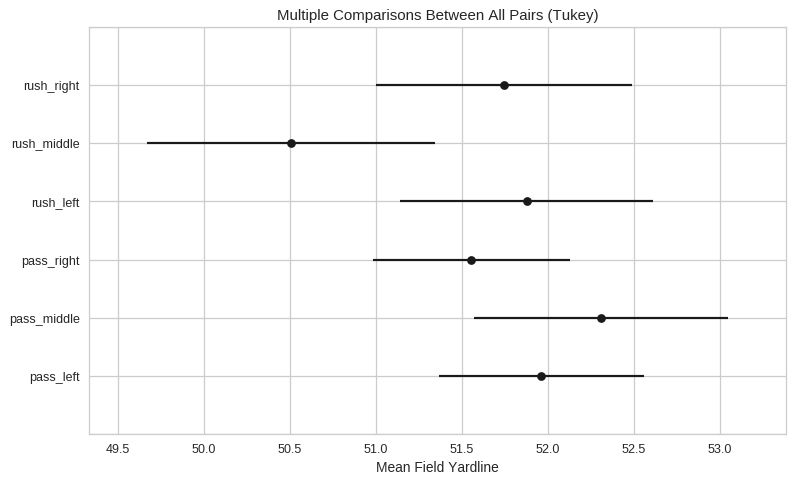

In [26]:
# pairwise comps
results, pvals = pairwiseMC(plays.yardfield, plays.play, alpha=0.05)
results.plot_simultaneous(xlabel='Mean Field Yardline')
print('p-values= {0}'.format(pvals))
results.summary()

In [51]:
def chisqIndDfSer(df, s1, s2):
    '''
    chi-square test of independence in contingency table
    using pandas DataFrame series
    '''
    grpn = df.groupby([s1, s2]).size()
    ct_f = grpn.unstack(s2)
    return(st.chi2_contingency(ct_f))

# Down and Play type: test of independence
chi square test in contingency table

Chi-square= 1997.9529225
 p-value= 0.0


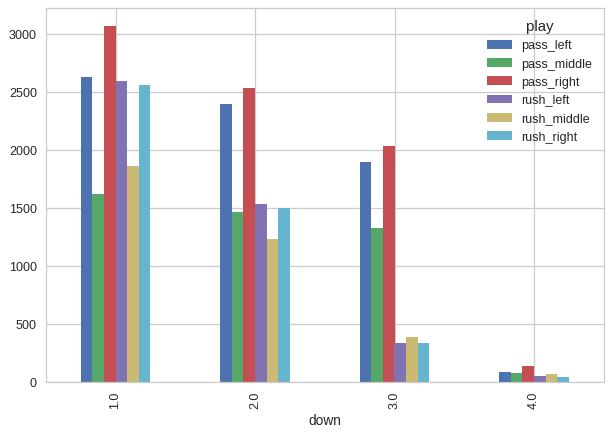

In [55]:
# Down and Play type: test of independence
## chi square test in contingency table
chi2, chi_p, chi_df, chi_e = chisqIndDfSer(plays, 'down', 'play')
print('Chi-square= {0}\n p-value= {1}'.format(chi2, chi_p))

s1 = 'down'
s2 = 'play'

gn = plays.groupby([s1, s2]).size()
gn.unstack(s2).plot.bar()

# Compare yards-to-go across each Play type
One-way ANOVA

In [20]:
# Compare yards to go across each play type
# One-way ANOVA
anova1DfCols(plays, 'yards_to_go', 'play')

yards_to_go compared between play 
 One-way ANOVA
                 sum_sq       df          F        PR(>F)
play        4589.284079      5.0  58.338561  1.173670e-60
Residual  499736.118672  31763.0        NaN           NaN

eta^2: 0.00909984715116


p-values= [ 0.06492175  0.4901038   0.001       0.001       0.001       0.001       0.001
  0.001       0.001       0.001       0.001       0.001       0.06285547
  0.9         0.00440157]


group1,group2,meandiff,lower,upper,reject
pass_left,pass_middle,0.2089,-0.0071,0.4249,False
pass_left,pass_right,-0.1152,-0.3014,0.071,False
pass_left,rush_left,-0.6874,-0.9031,-0.4717,True
pass_left,rush_middle,-0.9338,-1.1667,-0.7008,True
pass_left,rush_right,-0.6126,-0.8295,-0.3957,True
pass_middle,pass_right,-0.3241,-0.536,-0.1123,True
pass_middle,rush_left,-0.8963,-1.1345,-0.6581,True
pass_middle,rush_middle,-1.1427,-1.3966,-0.8888,True
pass_middle,rush_right,-0.8215,-1.0608,-0.5823,True
pass_right,rush_left,-0.5722,-0.7837,-0.3607,True


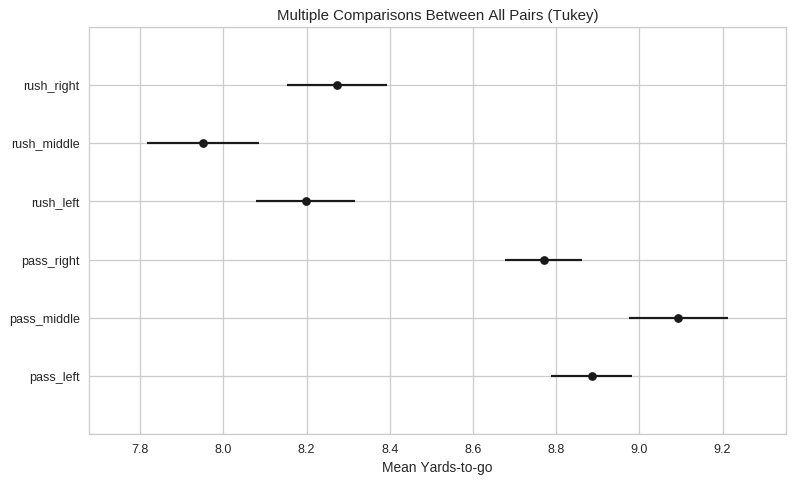

In [23]:
# pairwise comps
results, pvals = pairwiseMC(plays.yards_to_go, plays.play, alpha=0.05)
results.plot_simultaneous(xlabel='Mean Yards-to-go')
print('p-values= {0}'.format(pvals))
results.summary()

# Compare Score Difference across each Play type
One-way ANOVA

In [21]:
# Compare score diff across each play type
# One-way ANOVA
anova1DfCols(plays, 'score_diff', 'play')

score_diff compared between play 
 One-way ANOVA
                sum_sq       df           F         PR(>F)
play      8.314041e+04      5.0  166.098435  5.845977e-175
Residual  3.179788e+06  31763.0         NaN            NaN

eta^2: 0.0254803065924


p-values= [ 0.11145847  0.9         0.001       0.001       0.001       0.00658154
  0.001       0.001       0.001       0.001       0.001       0.001
  0.00854201  0.9         0.04339664]


group1,group2,meandiff,lower,upper,reject
pass_left,pass_middle,-0.4866,-1.0315,0.0583,False
pass_left,pass_right,0.1665,-0.3032,0.6363,False
pass_left,rush_left,3.4712,2.927,4.0153,True
pass_left,rush_middle,2.7057,2.1181,3.2933,True
pass_left,rush_right,3.3593,2.8122,3.9064,True
pass_middle,pass_right,0.6532,0.1188,1.1875,True
pass_middle,rush_left,3.9578,3.357,4.5586,True
pass_middle,rush_middle,3.1923,2.5518,3.8328,True
pass_middle,rush_right,3.8459,3.2424,4.4495,True
pass_right,rush_left,3.3046,2.771,3.8382,True


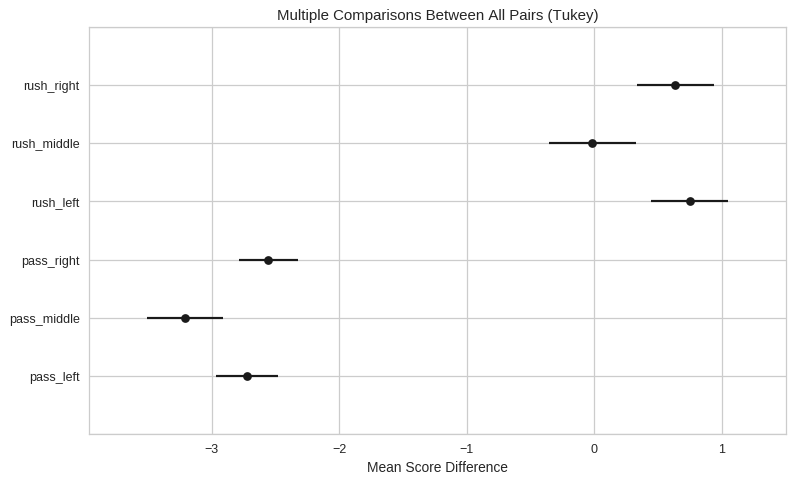

In [22]:
# pairwise comps
results, pvals = pairwiseMC(plays.score_diff, plays.play, alpha=0.05)
results.plot_simultaneous(xlabel='Mean Score Difference')
print('p-values= {0}'.format(pvals))
results.summary()

In [47]:
# compute total frequency and percent of play types over all teams
tot_f = plays.play.value_counts().sort_index().values
tot_per = tot_f / plays.play.value_counts().sum()
tot_per, tot_f

(array([ 0.2205924 ,  0.14145865,  0.24460953,  0.14211968,  0.11161824,
         0.1396015 ]), array([7008, 4494, 7771, 4515, 3546, 4435]))

In [ ]:
plays.play.value_counts().sort_index()

In [49]:
teams_n = plays.pos_team.unique().shape[0]
plays_n = plays.play.unique().shape[0]
# frequency counts of play types for each team
team_plays_f = plays.groupby(['pos_team']).play.value_counts().sort_index().values
team_plays_f = np.reshape(team_plays_f, (teams_n, plays_n))
# expected counts
team_plays_e = np.multiply(np.tile(tot_per, (teams_n, 1)).transpose(1,0), np.sum(team_plays_f, 1)).transpose(1,0)

In [50]:
st.chisquare(team_plays_f, team_plays_e)

Power_divergenceResult(statistic=array([  90.06113061,  184.14064429,   54.12105397,  167.55086603,
        479.94052861,  164.296536  ]), pvalue=array([  1.14055512e-07,   1.10325508e-23,   6.23632385e-03,
         1.14398020e-20,   6.26081755e-82,   4.39861849e-20]))

# Plot play counts by team

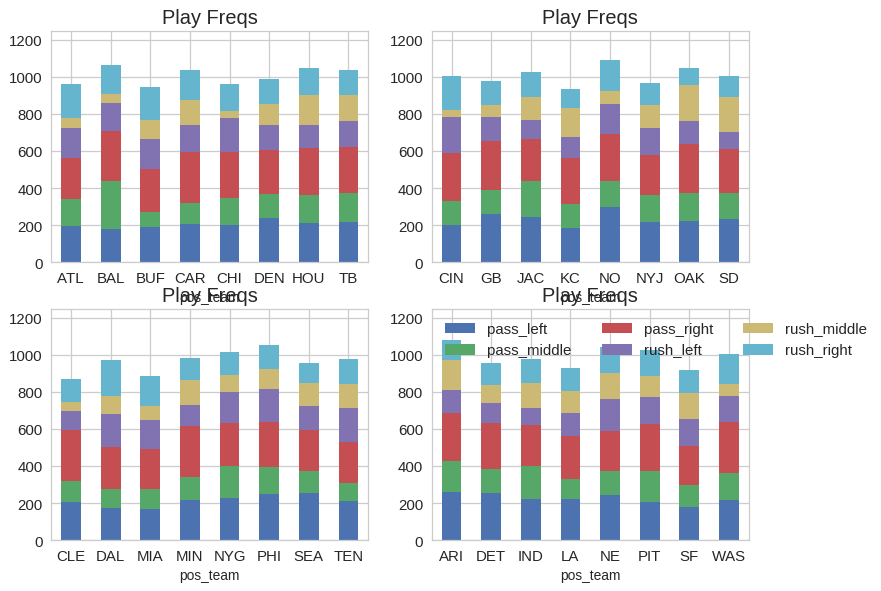

In [65]:
teams = plays['pos_team'].unique().sort_values()
# configure max ylim across teams
ymax = plays.groupby(['pos_team', 'play']).size().unstack().sum(1).max()
# round ylim up: to nearest 10000
#m + (250 - m) % 250
ymax = math.ceil(ymax / 250) * 250.0
fig = plt.figure()
#fig, axes = plt.subplots(2, 2)
mpl.rcParams['font.size'] = 24
axshow = False, False, False, True
for i in range(0, len(teams), 8):
    j = i//8+1
    team8 = (plays['pos_team']==teams[i]) | (plays['pos_team']==teams[i+1]) | (plays['pos_team']==teams[i+2]) | (plays['pos_team']==teams[i+3]) | (plays['pos_team']==teams[i+4]) | (plays['pos_team']==teams[i+5]) | (plays['pos_team']==teams[i+6]) | (plays['pos_team']==teams[i+7])
    d = plays[team8]
    ax = fig.add_subplot(2, 2, j)
    d.groupby(['pos_team', 'play']).size().unstack().plot.bar(ax=ax, ylim=(0, ymax), stacked=True, figsize=[10, 7.5], fontsize=12, rot=0, legend=axshow[j-1])
    ax.set_title('Play Freqs', fontsize=16)
    if j == 4:
        ax.legend(loc=2, ncol=3, fontsize=12)

# Correlations of potential feature predictors

In [53]:
# incoporate new features and dummy cols in features array
adfeat = ['quarter_code', 'qtr_timef', 'down', 'yards_to_go', 'score_diff', 'week', 'home', 'yardfield']
dumPrefix = ['off_', 'def_', 'day_']
catExc = ['pos_team', 'def_team', 'day_of_week']
dumCols = [c for c in plays.columns for d in dumPrefix if c.startswith(d) and c not in catExc]
features = cumCols + prevPlay + adfeat + dumCols
features = np.load('data/features_dum.npy')
# not in ['rushing_loss_cum_gm', 'rushing_loss_yds_cum_gm']
features = [f for f in features if not f.startswith('rushing_loss') and f not in ['passing_int_cum_dr']]

In [33]:
# Continuous features and  targets (play type and play direction)
exc = ['off_', 'def_', 'day_']
#featuresCont = [f for f in features for e in exc if not f.startswith(e)]
featuresCont = [f for f in features if not f.startswith('off_') and not f.startswith('def_') and not f.startswith('day_')]

# Correlations of cumulative game features

In [40]:
def corrQtile75(df, features, suffix):
    feat = [f for f in features if f.endswith(suffix)]
    corr = df[feat].corr()
    qtiles = corr.quantile([.25, .5, .75]).T
    print('Pearsonr Quartiles: \n {}'.format(qtiles))
    return corr, qtiles

In [41]:
# 75th percentile r-values
corr, qtiles = corrQtile75(plays, featuresCont, '_gm')
corr[corr>qtiles.iloc[:, 2]]

Pearsonr Quartiles: 
                                   0.25      0.50      0.75
first_down_cum_gm             0.587440  0.760327  0.874757
fourth_down_att_cum_gm        0.200893  0.317434  0.375394
fourth_down_failed_cum_gm     0.135379  0.212196  0.254766
offense_tds_cum_gm            0.378570  0.582484  0.620341
offense_yds_cum_gm            0.620524  0.752828  0.877056
passing_att_cum_gm            0.512417  0.771368  0.891398
passing_cmp_cum_gm            0.551921  0.727198  0.886204
passing_first_down_cum_gm     0.551861  0.703928  0.871230
passing_incmp_cum_gm          0.397268  0.685052  0.756445
passing_incmp_air_yds_cum_gm  0.345590  0.590148  0.651482
passing_int_cum_gm            0.205872  0.286558  0.319123
passing_sk_cum_gm             0.002483  0.013970  0.029741
passing_sk_yds_cum_gm        -0.030264 -0.014738 -0.002341
passing_tds_cum_gm            0.290931  0.447537  0.562361
passing_yds_cum_gm            0.545626  0.696312  0.887663
receiving_rec_cum_gm          0.55

,first_down_cum_gm,fourth_down_att_cum_gm,fourth_down_failed_cum_gm,offense_tds_cum_gm,offense_yds_cum_gm,passing_att_cum_gm,passing_cmp_cum_gm,passing_first_down_cum_gm,passing_incmp_cum_gm,passing_incmp_air_yds_cum_gm,...,rushing_tds_cum_gm,rushing_yds_cum_gm,third_down_att_cum_gm,third_down_conv_cum_gm,third_down_failed_cum_gm,type_pass_cum_gm,type_rush_cum_gm,dir_left_cum_gm,dir_middle_cum_gm,dir_right_cum_gm
first_down_cum_gm,1.000000,NaN,NaN,0.734627,0.947014,NaN,0.898523,0.930678,NaN,NaN,...,0.478146,0.747661,NaN,0.760489,NaN,NaN,0.859354,0.855111,NaN,0.856869
fourth_down_att_cum_gm,NaN,1.000000,0.597762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fourth_down_failed_cum_gm,NaN,0.597762,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offense_tds_cum_gm,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,0.622707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offense_yds_cum_gm,0.947014,NaN,NaN,0.740974,1.000000,NaN,0.905011,0.912569,NaN,NaN,...,0.443966,0.761414,NaN,0.744242,NaN,NaN,0.851567,0.848514,NaN,0.853475
passing_att_cum_gm,0.879892,0.407009,0.282214,NaN,0.887245,1.000000,0.960711,0.895799,0.892783,0.770084,...,NaN,NaN,0.903583,0.737481,0.798806,0.996080,NaN,0.869482,0.772653,0.874811
passing_cmp_cum_gm,0.898523,0.378811,NaN,NaN,0.905011,0.960711,1.000000,0.928658,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.956441,NaN,0.842646,0.724770,0.844243
passing_first_down_cum_gm,0.930678,NaN,NaN,0.683681,0.912569,0.895799,0.928658,1.000000,NaN,NaN,...,NaN,NaN,NaN,0.744682,NaN,0.889032,NaN,NaN,NaN,NaN
passing_incmp_cum_gm,NaN,0.383183,0.282285,NaN,NaN,0.892783,NaN,NaN,1.000000,0.877083,...,NaN,NaN,0.865325,NaN,0.840893,0.890103,NaN,NaN,NaN,NaN
passing_incmp_air_yds_cum_gm,NaN,NaN,0.255541,NaN,NaN,NaN,NaN,NaN,0.877083,1.000000,...,NaN,NaN,NaN,NaN,0.739639,NaN,NaN,NaN,NaN,NaN


# Correlations of cumulative DRIVE features

In [42]:
# 75th percentile r-values
corr, qtiles = corrQtile75(plays, featuresCont, '_dr')
corr[corr>qtiles.iloc[:, 2]]

Pearsonr Quartiles: 
                                   0.25      0.50      0.75
first_down_cum_dr             0.146205  0.599869  0.775296
fourth_down_att_cum_dr        0.042426  0.163306  0.210868
fourth_down_failed_cum_dr    -0.000045  0.005668  0.018248
offense_tds_cum_dr            0.009425  0.015396  0.031560
offense_yds_cum_dr            0.137903  0.588729  0.761294
passing_att_cum_dr            0.145212  0.616904  0.764873
passing_cmp_cum_dr            0.141252  0.559444  0.795401
passing_cmp_air_yds_cum_dr    0.083197  0.389476  0.675937
passing_first_down_cum_dr     0.130323  0.525414  0.816766
passing_incmp_cum_dr          0.090207  0.367530  0.409463
passing_incmp_air_yds_cum_dr  0.061472  0.267169  0.299235
passing_sk_cum_dr            -0.003140 -0.000076  0.003111
passing_sk_yds_cum_dr        -0.003111  0.000076  0.003140
passing_tds_cum_dr            0.000036  0.016829  0.022579
passing_yds_cum_dr            0.113954  0.494674  0.798011
receiving_rec_cum_dr          0.14

,first_down_cum_dr,fourth_down_att_cum_dr,fourth_down_failed_cum_dr,offense_tds_cum_dr,offense_yds_cum_dr,passing_att_cum_dr,passing_cmp_cum_dr,passing_cmp_air_yds_cum_dr,passing_first_down_cum_dr,passing_incmp_cum_dr,...,rushing_att_cum_dr,rushing_tds_cum_dr,rushing_yds_cum_dr,third_down_att_cum_dr,third_down_conv_cum_dr,type_pass_cum_dr,type_rush_cum_dr,dir_left_cum_dr,dir_middle_cum_dr,dir_right_cum_dr
first_down_cum_dr,1.000000,NaN,NaN,NaN,0.886105,0.781770,0.801252,NaN,0.841154,NaN,...,0.645169,NaN,0.539433,0.578174,0.560515,0.797781,0.648226,0.691860,0.586930,0.683169
fourth_down_att_cum_dr,NaN,1.000000,0.035437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fourth_down_failed_cum_dr,NaN,NaN,1.000000,0.408216,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.499976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offense_tds_cum_dr,NaN,NaN,0.408216,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.816471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offense_yds_cum_dr,0.886105,NaN,NaN,NaN,1.000000,NaN,NaN,0.767455,0.822684,NaN,...,0.607682,NaN,0.561939,NaN,NaN,NaN,0.612533,0.643834,0.558845,0.646294
passing_att_cum_dr,0.781770,0.279973,NaN,NaN,NaN,1.000000,0.933919,0.686386,0.836052,0.698874,...,NaN,NaN,NaN,0.666654,0.603534,0.983204,NaN,0.630274,0.588640,0.663721
passing_cmp_cum_dr,0.801252,0.238989,NaN,NaN,0.793450,0.933919,1.000000,0.708578,0.869747,NaN,...,NaN,NaN,NaN,0.613616,0.570629,0.916714,NaN,NaN,0.548259,0.634673
passing_cmp_air_yds_cum_dr,NaN,NaN,NaN,NaN,0.767455,NaN,NaN,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passing_first_down_cum_dr,0.841154,NaN,NaN,NaN,0.822684,0.836052,0.869747,0.766312,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,0.814794,NaN,NaN,NaN,NaN
passing_incmp_cum_dr,NaN,0.240649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Correlations of PREVIOUS PLAY features

In [43]:
# 75th percentile r-values
corr, qtiles = corrQtile75(plays, featuresCont, '_sh1')
corr[corr>qtiles.iloc[:, 2]]

Pearsonr Quartiles: 
                                0.25      0.50      0.75
first_down_sh1            -0.005226  0.154707  0.403132
fourth_down_att_sh1        0.000839  0.008337  0.023557
fourth_down_conv_sh1       0.000663  0.016275  0.041663
fourth_down_failed_sh1    -0.024381 -0.005939  0.004786
offense_yds_sh1           -0.005437  0.156625  0.501912
passing_att_sh1            0.006919  0.118813  0.343910
passing_cmp_sh1           -0.079467  0.026660  0.502517
passing_cmp_air_yds_sh1   -0.041529  0.037275  0.343910
passing_first_down_sh1    -0.052831  0.048229  0.478179
passing_incmp_sh1         -0.251893 -0.078113  0.012569
passing_incmp_air_yds_sh1 -0.170253 -0.052796  0.017732
passing_int_sh1           -0.052831 -0.016383  0.008641
passing_sk_sh1            -0.005437 -0.002976 -0.000891
passing_sk_yds_sh1         0.000888  0.002964  0.005415
passing_tds_sh1           -0.016383  0.023557  0.206162
passing_yds_sh1           -0.053217  0.032576  0.521180
receiving_rec_sh1         

,first_down_sh1,fourth_down_att_sh1,fourth_down_conv_sh1,fourth_down_failed_sh1,offense_yds_sh1,passing_att_sh1,passing_cmp_sh1,passing_cmp_air_yds_sh1,passing_first_down_sh1,passing_incmp_sh1,...,rushing_att_sh1,rushing_first_down_sh1,rushing_tds_sh1,rushing_yds_sh1,third_down_conv_sh1,type_pass_sh1,type_rush_sh1,dir_left_sh1,dir_middle_sh1,dir_right_sh1
first_down_sh1,1.000000,0.073480,0.125444,NaN,0.593731,NaN,NaN,0.459920,0.744551,NaN,...,NaN,0.455543,0.165845,0.189480,0.438350,NaN,NaN,NaN,0.038649,NaN
fourth_down_att_sh1,NaN,1.000000,0.790250,0.608494,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fourth_down_conv_sh1,NaN,0.790250,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.041663,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fourth_down_failed_sh1,NaN,0.608494,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.061786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
offense_yds_sh1,0.593731,NaN,NaN,NaN,1.000000,NaN,NaN,0.703762,0.612843,NaN,...,NaN,0.159453,NaN,0.333676,NaN,NaN,NaN,NaN,0.034491,NaN
passing_att_sh1,NaN,NaN,NaN,0.009594,NaN,1.000000,0.658081,NaN,NaN,0.447467,...,NaN,NaN,NaN,NaN,NaN,0.932282,NaN,0.015911,NaN,0.057633
passing_cmp_sh1,NaN,NaN,0.043009,NaN,NaN,0.658081,1.000000,0.522596,0.664815,NaN,...,NaN,NaN,NaN,NaN,0.264541,0.613517,NaN,NaN,NaN,0.026660
passing_cmp_air_yds_sh1,0.459920,NaN,NaN,NaN,0.703762,NaN,0.522596,1.000000,0.638820,NaN,...,NaN,NaN,NaN,NaN,0.252691,NaN,NaN,NaN,0.059289,NaN
passing_first_down_sh1,0.744551,0.048229,0.085529,NaN,0.612843,0.437502,0.664815,0.638820,1.000000,NaN,...,NaN,NaN,NaN,NaN,0.435901,0.407875,NaN,NaN,NaN,NaN
passing_incmp_sh1,NaN,NaN,NaN,0.061786,NaN,0.447467,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,0.417166,NaN,0.012569,NaN,0.039172


# see notebook: plays_greedy_feature_select.ipynb, 

## For reduction of inter dependent features (e.g., high colinearity)